In [ ]:
# Import essential libraries
import struct
import numpy as np
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D, add, concatenate
from keras.models import Model
from google.colab import drive
import os

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/Colab_Notebooks/Assignment_CV/vehicle_dataset/'
os.chdir(folder_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# https://github.com/experiencor/keras-yolo3
# Dataset yolov3 trained on

def make_conv_layer(input_tensor, conv_params, skip=True):
    # Initialize x with the input tensor
    x = input_tensor
    count = 0
    for conv in conv_params:
        # Save skip connection tensor before the last conv if skipping is enabled
        if count == (len(conv_params) - 2) and skip:
            skip_tensor = x
        count += 1

        # Apply custom padding (as used in Darknet) only when stride > 1
        if conv['stride'] > 1:
            x = ZeroPadding2D(((1,0),(1,0)))(x)  # pad top and left

        # Apply convolutional layer
        x = Conv2D(conv['filter'],
                   conv['kernel'],
                   strides=conv['stride'],
                   padding='valid' if conv['stride'] > 1 else 'same',
                   name='conv_' + str(conv['layer_idx']),
                   use_bias=not conv['bnorm'])(x)

        # Apply BatchNorm if specified
        if conv['bnorm']:
            x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)

        # Apply Leaky ReLU if specified
        if conv['leaky']:
            x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    # Return either the residual connection or just the processed tensor
    return add([skip_tensor, x]) if skip else x


def build_yolov3():

	# Input tensor: shape is flexible height/width with 3 color channels
	input_image = Input(shape=(None, None, 3))

	# Layer  0 => 4
	feature_map = make_conv_layer(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
								  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
								  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
								  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

	# Layer  5 => 8
	feature_map = make_conv_layer(feature_map, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
						{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

	# Layer  9 => 11
	feature_map = make_conv_layer(feature_map, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

	# Layer 12 => 15
	feature_map = make_conv_layer(feature_map, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
						{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
						{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

	# Layer 16 => 36
	for i in range(7):
		feature_map = make_conv_layer(feature_map, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
							{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
	skip_layer_36 = feature_map

	# Layer 37 => 40
	feature_map = make_conv_layer(feature_map, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

	# Layer 41 => 61
	for i in range(7):
		feature_map = make_conv_layer(feature_map, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
							{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
	skip_layer_61 = feature_map

	# Layer 62 => 65
	feature_map = make_conv_layer(feature_map, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

	# Layer 66 => 74
	for i in range(3):
		feature_map = make_conv_layer(feature_map, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
							{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])

	# Layer 75 => 79
	feature_map = make_conv_layer(feature_map, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

	# Layer 80 => 82
	# YOLO output 1 (13x13 for 416 input)
	yolo_82 = make_conv_layer(feature_map, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
							  {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

	# Layer 83 => 86
	# Upsample and merge with skip connection, YOLO output 2 (26x26)
	feature_map = make_conv_layer(feature_map, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
	feature_map = UpSampling2D(2)(feature_map)
	feature_map = concatenate([feature_map, skip_layer_61])

	# Layer 87 => 91
	feature_map = make_conv_layer(feature_map, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

	# Layer 92 => 94
	# Upsample and merge with earlier skip, YOLO output 3 (52x52)
	yolo_94 = make_conv_layer(feature_map, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
							  {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

	# Layer 95 => 98
	feature_map = make_conv_layer(feature_map, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
	feature_map = UpSampling2D(2)(feature_map)
	feature_map = concatenate([feature_map, skip_layer_36])

	# Layer 99 => 106
	yolo_106 = make_conv_layer(feature_map, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
							   {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

  # Construct and return the model
	model = Model(input_image, [yolo_82, yolo_94, yolo_106])
	return model

class WeightReader:
    def __init__(self, weight_file):
        # Load binary weights from file
        with open(weight_file, 'rb') as w_f:
            major, = struct.unpack('i', w_f.read(4))
            minor, = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))
            if (major * 10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)  # Skip extra header for newer versions
            else:
                w_f.read(4)
            transpose = (major > 1000) or (minor > 1000)
            weight_data = w_f.read()

        # Store weights as a flat float32 array
        self.offset = 0
        self.all_weights = np.frombuffer(weight_data, dtype='float32')

    def read_bytes(self, layer_weight_size):
        # Read the next chunk of weights
        self.offset += layer_weight_size
        return self.all_weights[self.offset-layer_weight_size:self.offset]

    def load_weights(self, model):
        # Load weights into each conv + batchnorm layer
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                # If batchnorm is used (i.e., not one of the YOLO heads)
                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))
                    layer_weight_size = np.prod(norm_layer.get_weights()[0].shape)
                    beta = self.read_bytes(layer_weight_size)
                    gamma = self.read_bytes(layer_weight_size)
                    mean = self.read_bytes(layer_weight_size)
                    variance = self.read_bytes(layer_weight_size)
                    norm_layer.set_weights([gamma, beta, mean, variance])

                # Convolution weights (and bias if present)
                if len(conv_layer.get_weights()) > 1:
                    bias = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))

    def reset(self):
        self.offset = 0




# (libraries) used to load and prepare images for prediction
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array


def load_image_pixels(filename, shape):
		# Load and prepare an image for prediction
    image = load_img(filename)  # load original image
    width, height = image.size
    image = load_img(filename, target_size=shape)  # resize to model input
    image = img_to_array(image)  # convert to numpy array
    image = image.astype('float32') / 255.0  # normalize
    image = expand_dims(image, 0)  # model expects batch dimension
    return image, width, height

# Build the model and load pre-trained weights
model = build_yolov3() # define the model
weight_reader = WeightReader('yolov3.weights') # load the model weights
weight_reader.load_weights(model) # set the model weights into the model
model.save('model.h5') # save the keras model in a file

# Load model and make a prediction
model = load_model('model.h5')
input_width, input_height = 416, 416
photo_filename = 'test_images/bus.jpg'
image, image_width, image_height = load_image_pixels(photo_filename, (input_width, input_height))
yhat = model.predict(image)  # perform inference
print([a.shape for a in yhat])  # print output shapes of YOLO heads

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

loading weights of convolution #88
loading weights of convolution #89
loading weights of convolution #90
loading weights of convolution #91
loading weights of convolution #92
loading weights of convolution #93
no convolution #94
no convolution #95
loading weights of convolution #96
no convolution #97
no convolution #98
loading weights of convolution #99
loading weights of convolution #100
loading weights of convolution #101
loading weights of convolution #102
loading weights of convolution #103
loading weights of convolution #104
loading weights of convolution #105


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Model output shapes: [(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
truck: 84.26%
car: 67.85%


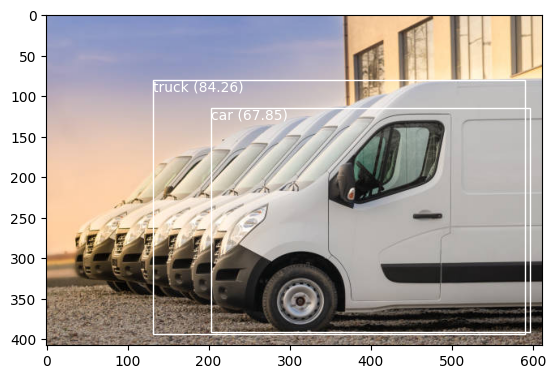

In [ ]:
# Importing required libraries used for bounding box
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

# -------------------------------
# Helper class for bounding boxes
# -------------------------------
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objectness_score=None, classes=None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objectness_score = objectness_score
        self.classes = classes
        self.label = -1  # Cached label index
        self.score = -1  # Cached confidence score

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        return self.score

# -------------------------------
# Utility Functions
# -------------------------------

def sigmoid(x):
    # Apply sigmoid activiation function
    return 1. / (1. + np.exp(-x))

def decode_netout(network_output, anchors, obj_thresh, net_h, net_w):
    # Decode the YOLO model output to extract bounding boxes
    # Converts the raw output from the YOLO model into a list of bounding boxes.
    # Each box includes coordinates, objectness score, and class probabilities.
    grid_height, grid_width = network_output.shape[:2]
    num_boxes = 3
    network_output = network_output.reshape((grid_height, grid_width, num_boxes, -1))
    num_classes = network_output.shape[-1] - 5
    boxes = []

    network_output[..., :2] = sigmoid(network_output[..., :2])
    network_output[..., 4:] = sigmoid(network_output[..., 4:])
    network_output[..., 5:] = network_output[..., 4][..., np.newaxis] * network_output[..., 5:]
    network_output[..., 5:] *= network_output[..., 5:] > obj_thresh

    for row in range(grid_height):
        for col in range(grid_width):
            for b in range(num_boxes):
                objectness = network_output[row][col][b][4]
                if objectness <= obj_thresh:
                    continue
                x, y, w, h = network_output[row][col][b][:4]
                x = (col + x) / grid_width
                y = (row + y) / grid_height
                w = anchors[2 * b] * np.exp(w) / net_w
                h = anchors[2 * b + 1] * np.exp(h) / net_h
                classes = network_output[row][col][b][5:]
                box = BoundBox(x - w/2, y - h/2, x + w/2, y + h/2, objectness, classes)
                boxes.append(box)
    return boxes

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    # Adjust box coordinates based on the original image size
    for box in boxes:
        box.xmin = int(box.xmin * image_w)
        box.xmax = int(box.xmax * image_w)
        box.ymin = int(box.ymin * image_h)
        box.ymax = int(box.ymax * image_h)

def interval_overlap(a, b):
    # Calculate overlapping length between two 1D intervals
    return max(0, min(a[1], b[1]) - max(a[0], b[0]))

def bounding_box_iou(box1, box2):
    # Compute Intersection over Union (IoU) between two boxes
    inter_width = interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    inter_height = interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    inter_area = inter_width * inter_height

    area1 = (box1.xmax - box1.xmin) * (box1.ymax - box1.ymin)
    area2 = (box2.xmax - box2.xmin) * (box2.ymax - box2.ymin)
    union = area1 + area2 - inter_area

    return inter_area / union if union > 0 else 0

def non_max_suppression(boxes, nms_threshold):
    # Apply Non-Maximum Suppression to reduce overlapping boxes
    # Keeps the highest-scoring boxes for each class.
    if not boxes:
        return
    num_classes = len(boxes[0].classes)
    for c in range(num_classes):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0:
                continue
            for j in range(i + 1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bounding_box_iou(boxes[index_i], boxes[index_j]) >= nms_threshold:
                    boxes[index_j].classes[c] = 0

# -------------------------------
# Image Handling and Visualization
# -------------------------------

def load_image_pixels(filename, shape):
    # Load image and resize it to the network input shape
    image = load_img(filename)
    width, height = image.size
    image = load_img(filename, target_size=shape)
    image = img_to_array(image).astype('float32') / 255.0
    image = expand_dims(image, 0)
    return image, width, height

def get_boxes(boxes, labels, threshold):
    # Filter out boxes with scores below the threshold
    valid_boxes, valid_labels, valid_scores = [], [], []
    for box in boxes:
        for i in range(len(labels)):
            if box.classes[i] > threshold:
                valid_boxes.append(box)
                valid_labels.append(labels[i])
                valid_scores.append(box.classes[i] * 100)
    return valid_boxes, valid_labels, valid_scores

def draw_boxes(filename, valid_boxes, valid_labels, valid_scores):
    # Draw the final boxes with labels and confidence scores
    data = plt.imread(filename)
    plt.imshow(data)
    ax = plt.gca()
    for i, box in enumerate(valid_boxes):
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        width, height = x2 - x1, y2 - y1
        rectangle = Rectangle((x1, y1), width, height, fill=False, color='white')
        ax.add_patch(rectangle)
        label = f"{valid_labels[i]} ({valid_scores[i]:.2f})"
        plt.text(x1, y1, label, color='white', fontsize=10, verticalalignment='top')
    plt.show()

# -------------------------------
# YOLO Inference
# -------------------------------

# Load the pre-trained model
model = load_model('model.h5')

# Input and image parameters
input_width, input_height = 416, 416
photo_filename = 'test_images/vehicle1.jpg'

# Load and preprocess image
image, image_w, image_h = load_image_pixels(photo_filename, (input_width, input_height))

# Predict using YOLO model
prediction = model.predict(image)
print("Model output shapes:", [a.shape for a in prediction])

# Anchors for each YOLO output layer
anchors = [
    [116,90, 156,198, 373,326],
    [30,61, 62,45, 59,119],
    [10,13, 16,30, 33,23]
]

# Minimum probability threshold for classification
class_threshold = 0.6

# Decode YOLO predictions into bounding boxes
boxes = []
for i in range(len(prediction)):
    boxes += decode_netout(prediction[i][0], anchors[i], class_threshold, input_height, input_width)

# Correct box sizes and apply Non-Maximum Suppression (NMS)
correct_yolo_boxes(boxes, image_h, image_w, input_height, input_width)
non_max_suppression(boxes, nms_threshold=0.5)

# COCO object class labels
labels = [
    "person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]

# Filter out final boxes, labels and confidence scores
valid_boxes, valid_labels, valid_scores = get_boxes(boxes, labels, class_threshold)

# Display detected objects
for i in range(len(valid_boxes)):
    print(f"{valid_labels[i]}: {valid_scores[i]:.2f}%")

# Draw final detections on the image
draw_boxes(photo_filename, valid_boxes, valid_labels, valid_scores)


Processing 129 images for validation.


Evaluating:   0%|          | 0/129 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Evaluating:   1%|          | 1/129 [00:04<08:38,  4.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:   2%|▏         | 2/129 [00:04<03:42,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Evaluating:   2%|▏         | 3/129 [00:04<02:31,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:   3%|▎         | 4/129 [00:05<01:57,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:   4%|▍         | 5/129 [00:05<01:20,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:   5%|▍         | 6/129 [00:05<00:58,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:   5%|▌         | 7/129 [00:06<01:01,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Evaluating:   6%|▌         | 8/129 [00:06<00:48,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:   7%|▋         | 9/129 [00:06<00:56,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Evaluating:   8%|▊         | 10/129 [00:07<00:54,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:   9%|▊         | 11/129 [00:10<02:40,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:   9%|▉         | 12/129 [00:11<02:06,  1.08s/it]

[WARNING] No labels or predictions found for valid/images/canva-tuk-tuk-in-sri-lanka-MADAsrumKyk.jpg. Skipping...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  10%|█         | 13/129 [00:11<01:31,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  11%|█         | 14/129 [00:11<01:21,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  12%|█▏        | 15/129 [00:12<01:09,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  12%|█▏        | 16/129 [00:12<00:53,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  13%|█▎        | 17/129 [00:12<00:55,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  14%|█▍        | 18/129 [00:13<00:42,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  15%|█▍        | 19/129 [00:13<00:46,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  16%|█▌        | 20/129 [00:14<00:49,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  16%|█▋        | 21/129 [00:14<00:48,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  17%|█▋        | 22/129 [00:14<00:48,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  18%|█▊        | 23/129 [00:15<00:46,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:  19%|█▊        | 24/129 [00:15<00:51,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  19%|█▉        | 25/129 [00:16<00:39,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  20%|██        | 26/129 [00:16<00:40,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  21%|██        | 27/129 [00:17<00:44,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  22%|██▏       | 28/129 [00:17<00:35,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  22%|██▏       | 29/129 [00:17<00:28,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  23%|██▎       | 30/129 [00:17<00:23,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Evaluating:  24%|██▍       | 31/129 [00:18<00:32,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  25%|██▍       | 32/129 [00:18<00:38,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:  26%|██▌       | 33/129 [00:19<00:45,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Evaluating:  26%|██▋       | 34/129 [00:19<00:35,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Evaluating:  27%|██▋       | 35/129 [00:19<00:29,  3.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Evaluating:  28%|██▊       | 36/129 [00:19<00:25,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Evaluating:  29%|██▊       | 37/129 [00:19<00:22,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Evaluating:  29%|██▉       | 38/129 [00:20<00:19,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Evaluating:  30%|███       | 39/129 [00:20<00:29,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  31%|███       | 40/129 [00:21<00:36,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  32%|███▏      | 41/129 [00:21<00:29,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  33%|███▎      | 42/129 [00:21<00:23,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  33%|███▎      | 43/129 [00:22<00:29,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  34%|███▍      | 44/129 [00:22<00:31,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  35%|███▍      | 45/129 [00:22<00:25,  3.36it/s]

[WARNING] No ground truth labels found for valid/images/canva-tuk-tuk-taxi-in-thailand-unique.-MADCjmS1xpg.jpg. Skipping...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  36%|███▋      | 47/129 [00:23<00:22,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  37%|███▋      | 48/129 [00:23<00:27,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  38%|███▊      | 49/129 [00:24<00:30,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Evaluating:  39%|███▉      | 50/129 [00:24<00:33,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  40%|███▉      | 51/129 [00:25<00:33,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  40%|████      | 52/129 [00:25<00:26,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  41%|████      | 53/129 [00:25<00:30,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  42%|████▏     | 54/129 [00:25<00:24,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  43%|████▎     | 55/129 [00:26<00:19,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  43%|████▎     | 56/129 [00:26<00:25,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  44%|████▍     | 57/129 [00:27<00:27,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  45%|████▍     | 58/129 [00:27<00:21,  3.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  46%|████▌     | 59/129 [00:27<00:17,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  47%|████▋     | 60/129 [00:28<00:28,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  47%|████▋     | 61/129 [00:28<00:27,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  48%|████▊     | 62/129 [00:28<00:21,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  49%|████▉     | 63/129 [00:29<00:24,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  50%|████▉     | 64/129 [00:29<00:25,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  50%|█████     | 65/129 [00:29<00:20,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  51%|█████     | 66/129 [00:30<00:24,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  52%|█████▏    | 67/129 [00:30<00:18,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  53%|█████▎    | 68/129 [00:30<00:22,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Evaluating:  53%|█████▎    | 69/129 [00:31<00:26,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:  54%|█████▍    | 70/129 [00:31<00:27,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:  55%|█████▌    | 71/129 [00:32<00:29,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Evaluating:  56%|█████▌    | 72/129 [00:33<00:29,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Evaluating:  57%|█████▋    | 73/129 [00:33<00:23,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  57%|█████▋    | 74/129 [00:33<00:24,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  58%|█████▊    | 75/129 [00:34<00:25,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  59%|█████▉    | 76/129 [00:34<00:19,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  60%|█████▉    | 77/129 [00:35<00:23,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  60%|██████    | 78/129 [00:35<00:24,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Evaluating:  61%|██████    | 79/129 [00:36<00:23,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  62%|██████▏   | 80/129 [00:36<00:18,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  63%|██████▎   | 81/129 [00:36<00:20,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  64%|██████▎   | 82/129 [00:37<00:22,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  64%|██████▍   | 83/129 [00:37<00:17,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  65%|██████▌   | 84/129 [00:37<00:13,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  66%|██████▌   | 85/129 [00:38<00:16,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  67%|██████▋   | 86/129 [00:38<00:18,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  67%|██████▋   | 87/129 [00:38<00:14,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  68%|██████▊   | 88/129 [00:39<00:15,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  69%|██████▉   | 89/129 [00:39<00:12,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  70%|██████▉   | 90/129 [00:40<00:14,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  71%|███████   | 91/129 [00:40<00:15,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  71%|███████▏  | 92/129 [00:40<00:11,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  72%|███████▏  | 93/129 [00:41<00:12,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  73%|███████▎  | 94/129 [00:41<00:10,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  74%|███████▎  | 95/129 [00:41<00:12,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  74%|███████▍  | 96/129 [00:42<00:13,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  75%|███████▌  | 97/129 [00:42<00:13,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  76%|███████▌  | 98/129 [00:43<00:14,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Evaluating:  77%|███████▋  | 99/129 [00:43<00:10,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Evaluating:  78%|███████▊  | 100/129 [00:43<00:12,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Evaluating:  78%|███████▊  | 101/129 [00:44<00:13,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Evaluating:  79%|███████▉  | 102/129 [00:44<00:10,  2.64it/s]

[WARNING] No labels or predictions found for valid/images/gettyimages-1161254933-612x612.jpg. Skipping...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  80%|███████▉  | 103/129 [00:44<00:08,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Evaluating:  81%|████████  | 104/129 [00:45<00:10,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Evaluating:  81%|████████▏ | 105/129 [00:45<00:09,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  82%|████████▏ | 106/129 [00:46<00:10,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  83%|████████▎ | 107/129 [00:46<00:10,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  84%|████████▎ | 108/129 [00:47<00:07,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  84%|████████▍ | 109/129 [00:47<00:07,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  85%|████████▌ | 110/129 [00:48<00:08,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  86%|████████▌ | 111/129 [00:48<00:08,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  87%|████████▋ | 112/129 [00:49<00:08,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Evaluating:  88%|████████▊ | 113/129 [00:49<00:07,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  88%|████████▊ | 114/129 [00:49<00:05,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Evaluating:  89%|████████▉ | 115/129 [00:49<00:04,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  90%|████████▉ | 116/129 [00:50<00:03,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  91%|█████████ | 117/129 [00:50<00:02,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Evaluating:  91%|█████████▏| 118/129 [00:50<00:03,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  92%|█████████▏| 119/129 [00:51<00:03,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  93%|█████████▎| 120/129 [00:51<00:03,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Evaluating:  94%|█████████▍| 121/129 [00:51<00:02,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  95%|█████████▍| 122/129 [00:52<00:02,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  95%|█████████▌| 123/129 [00:52<00:02,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  96%|█████████▌| 124/129 [00:53<00:02,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Evaluating:  97%|█████████▋| 125/129 [00:53<00:01,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Evaluating:  98%|█████████▊| 126/129 [00:53<00:01,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating:  98%|█████████▊| 127/129 [00:54<00:00,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Evaluating:  99%|█████████▉| 128/129 [00:54<00:00,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Evaluating: 100%|██████████| 129/129 [00:54<00:00,  2.36it/s]

Final Ground Truth Count: 156
Final Prediction Count: 156

Precision: 0.02
Recall: 0.01
F1 Score: 0.01


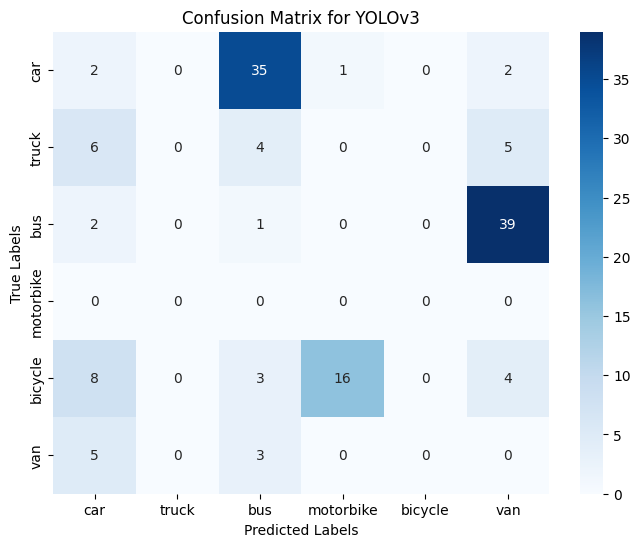

In [ ]:
import os
import numpy as np
import random
from glob import glob
from keras.models import load_model
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from keras.preprocessing.image import load_img, img_to_array
from numpy import expand_dims
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# -------------------------------
# Configuration
# -------------------------------
MODEL_PATH = "model.h5"
IMAGES_DIR = "valid/images"
LABELS_DIR = "valid/labels"
INPUT_DIM = (416, 416)
ANCHORS = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
CLASS_NAMES = ["car", "truck", "bus", "motorbike", "bicycle", "van"]  # Your 6 classes
CONF_THRESHOLD = 0.5
IOU_THRESHOLD = 0.5

# -------------------------------
# Helper Functions
# -------------------------------
model = load_model(MODEL_PATH)

def load_image(image_path):
    """Load and preprocess an image."""
    image = load_img(image_path, target_size=INPUT_DIM)
    image = img_to_array(image).astype("float32") / 255.0
    image = expand_dims(image, 0)
    return image

def load_ground_truth(label_path):
    """Load ground truth labels from a file."""
    if not os.path.exists(label_path):
        return []

    boxes = []
    with open(label_path, "r") as file:
        for line in file.readlines():
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            boxes.append([int(class_id), x_center, y_center, width, height])
    return boxes

# -------------------------------
# Evaluation Loop
# -------------------------------
all_predictions = []
all_ground_truths = []

# Limit dataset to 20% for faster evaluation
image_files = glob(os.path.join(IMAGES_DIR, "*.jpg"))
image_files = random.sample(image_files, k=int(len(image_files) * 0.2))

print(f"Processing {len(image_files)} images for validation.")

for image_path in tqdm(image_files, desc="Evaluating"):
    image_id = os.path.basename(image_path).split(".")[0]
    label_path = os.path.join(LABELS_DIR, f"{image_id}.txt")

    # Load image & labels
    image = load_image(image_path)
    ground_truth_boxes = load_ground_truth(label_path)

    # Skip images with missing ground truth labels
    if not ground_truth_boxes:
        print(f"[WARNING] No ground truth labels found for {image_path}. Skipping...")
        continue

    # Run YOLOv3 inference
    predictions = model.predict(image)  # Raw output

    # Decode YOLO output
    final_boxes = []
    for i, pred in enumerate(predictions):
        boxes = decode_netout(pred[0], ANCHORS[i], CONF_THRESHOLD, INPUT_DIM[1], INPUT_DIM[0])
        final_boxes += boxes

    # Ensure the number of labels match per image
    num_gt = len(ground_truth_boxes)
    num_pred = len(final_boxes)

    if num_gt == 0 or num_pred == 0:
        print(f"[WARNING] No labels or predictions found for {image_path}. Skipping...")
        continue

    matched_preds = final_boxes[:num_gt]  # Trim predictions to match ground truth count

    all_predictions.extend([box.get_label() for box in matched_preds])
    all_ground_truths.extend([gt[0] for gt in ground_truth_boxes])
# -------------------------------
# Calculate Metrics
# -------------------------------
if not all_ground_truths or not all_predictions:
    print("\nError: No valid predictions or ground-truth labels found!")
else:
    print(f"Final Ground Truth Count: {len(all_ground_truths)}")
    print(f"Final Prediction Count: {len(all_predictions)}")

    precision, recall, f1, _ = precision_recall_fscore_support(all_ground_truths, all_predictions, average="macro", zero_division=0)
    print(f"\nPrecision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    # -------------------------------
    # Compute & Plot Confusion Matrix
    # -------------------------------
    conf_matrix = confusion_matrix(all_ground_truths, all_predictions, labels=range(len(CLASS_NAMES)))

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix for YOLOv3")
    plt.show()

In [ ]:
import glob

train_images = glob.glob("/content/drive/MyDrive/Colab_Notebooks/Assignment_CV/vehicle_dataset/train/images/*.jpg")
valid_images = glob.glob("/content/drive/MyDrive/Colab_Notebooks/Assignment_CV/vehicle_dataset/valid/images/*.jpg")

print(f"Training Set Size: {len(train_images)} images")
print(f"Validation Set Size: {len(valid_images)} images")

Training Set Size: 1435 images
Validation Set Size: 649 images


In [ ]:
# Install ultralytics library to train yolov3 and yolov8
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
# ====================================================================================
# TRAIN YOLOv8 DEEP LEARNING ON VEHICLE DATASET
# ====================================================================================

from ultralytics import YOLO

# Initialize the YOLO model, specifying the configuration file (yolov8n.yaml)
# This sets up the model architecture for YOLO version 8 with a small (nano) configuration.
model = YOLO("yolov8n.yaml")  # Train from scratch

# Start training the YOLO model with the following parameters:
# data: Path to the dataset configuration file which defines the dataset and class labels.
# epochs: Number of training iterations (50 epochs).
# imgsz: Input image size for the model (640x640 pixels).
# batch: Number of images processed in one training step (batch size of 16).
model.train(data='/content/drive/MyDrive/Colab_Notebooks/Assignment_CV/vehicle_dataset/data.yaml', epochs=50, imgsz=640, batch=16)



Ultralytics 8.3.113 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/drive/MyDrive/Colab_Notebooks/Assignment_CV/vehicle_dataset/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_la

100%|██████████| 755k/755k [00:00<00:00, 20.5MB/s]

Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

YOLOv8n summary: 129 layers, 3,012,018 parameters, 3,012,002 gradients, 8.2 GFLOPs

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 96.9MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.7±0.4 ms, read: 0.1±0.1 MB/s, size: 62.0 KB)


train: Scanning /content/drive/MyDrive/Colab_Notebooks/Assignment_CV/vehicle_dataset/train/labels... 2100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2100/2100 [17:40<00:00,  1.98it/s]


train: New cache created: /content/drive/MyDrive/Colab_Notebooks/Assignment_CV/vehicle_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.7±0.3 ms, read: 0.4±0.4 MB/s, size: 183.8 KB)


val: Scanning /content/drive/MyDrive/Colab_Notebooks/Assignment_CV/vehicle_dataset/valid/labels... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/900 [07:09<00:00,  2.09it/s]

val: /content/drive/MyDrive/Colab_Notebooks/Assignment_CV/vehicle_dataset/valid/images/car55.jpg: corrupt JPEG restored and saved


val: New cache created: /content/drive/MyDrive/Colab_Notebooks/Assignment_CV/vehicle_dataset/valid/labels.cache
Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.12G      3.057      4.237      4.069         20        640: 100%|██████████| 132/132 [01:18<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:15<00:00,  1.89it/s]


                   all        900       1150    0.00394      0.692     0.0126    0.00375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.98G      2.642      3.735      3.319         13        640: 100%|██████████| 132/132 [00:51<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.86it/s]


                   all        900       1150      0.206     0.0461     0.0439     0.0136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.98G      2.091      3.342       2.73         10        640: 100%|██████████| 132/132 [00:49<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.54it/s]


                   all        900       1150      0.198      0.227      0.145     0.0628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.98G      1.775      2.925      2.365         18        640: 100%|██████████| 132/132 [00:48<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.61it/s]


                   all        900       1150        0.4      0.303      0.259      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.98G      1.609      2.586      2.187         13        640: 100%|██████████| 132/132 [00:50<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.75it/s]


                   all        900       1150      0.316      0.359      0.269      0.139

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.98G      1.474      2.312      2.032         14        640: 100%|██████████| 132/132 [00:48<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.52it/s]


                   all        900       1150      0.406      0.466      0.426      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.98G      1.383      2.128      1.935          9        640: 100%|██████████| 132/132 [00:50<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.01it/s]


                   all        900       1150      0.496      0.536      0.527      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.98G      1.308      1.988       1.85         14        640: 100%|██████████| 132/132 [00:49<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.63it/s]

                   all        900       1150      0.556      0.582      0.578        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.98G      1.247      1.837      1.782          8        640: 100%|██████████| 132/132 [00:50<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.52it/s]

                   all        900       1150      0.493      0.538      0.549      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.98G      1.198       1.76      1.735          9        640: 100%|██████████| 132/132 [00:53<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.57it/s]


                   all        900       1150      0.641      0.629      0.665      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.98G      1.178      1.703       1.72         15        640: 100%|██████████| 132/132 [00:51<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.43it/s]

                   all        900       1150      0.581      0.636      0.669       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.98G      1.088      1.559      1.632          6        640: 100%|██████████| 132/132 [00:54<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.44it/s]

                   all        900       1150       0.74      0.655      0.735      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.98G      1.086      1.523      1.621         11        640: 100%|██████████| 132/132 [00:52<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.82it/s]


                   all        900       1150      0.678      0.692      0.718      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.98G       1.06      1.462        1.6         12        640: 100%|██████████| 132/132 [00:56<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.15it/s]

                   all        900       1150      0.734      0.693      0.767      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.98G      1.034      1.452      1.577         19        640: 100%|██████████| 132/132 [01:02<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  2.04it/s]

                   all        900       1150      0.722      0.681      0.745      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.98G      1.012      1.385      1.551         11        640: 100%|██████████| 132/132 [01:01<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.21it/s]

                   all        900       1150      0.693      0.696      0.761      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.98G     0.9754      1.344      1.523         12        640: 100%|██████████| 132/132 [00:50<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.45it/s]

                   all        900       1150      0.754      0.738      0.783      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.98G     0.9708      1.295      1.509         14        640: 100%|██████████| 132/132 [00:50<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.56it/s]

                   all        900       1150      0.812      0.747      0.828      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.98G      0.931      1.261      1.489         12        640: 100%|██████████| 132/132 [00:49<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.51it/s]

                   all        900       1150      0.768       0.76      0.829      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.98G     0.9414      1.225      1.482         14        640: 100%|██████████| 132/132 [00:52<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.57it/s]


                   all        900       1150      0.812      0.751       0.84       0.69

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.98G     0.9031      1.175      1.451         12        640: 100%|██████████| 132/132 [00:50<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.45it/s]


                   all        900       1150      0.811      0.765      0.858       0.68

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.98G     0.9094      1.152      1.456         19        640: 100%|██████████| 132/132 [00:52<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.54it/s]


                   all        900       1150      0.824      0.797      0.861      0.701

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.98G     0.8822      1.131      1.429         18        640: 100%|██████████| 132/132 [00:50<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.59it/s]

                   all        900       1150      0.861      0.795      0.877      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.98G     0.8788      1.123      1.431         16        640: 100%|██████████| 132/132 [00:51<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.53it/s]

                   all        900       1150      0.865       0.79      0.889      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.98G     0.8581      1.077      1.413         12        640: 100%|██████████| 132/132 [00:50<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.46it/s]

                   all        900       1150      0.846      0.783      0.878      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.98G     0.8493      1.053      1.401         12        640: 100%|██████████| 132/132 [00:51<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.76it/s]


                   all        900       1150      0.877      0.788      0.888      0.737

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.98G     0.8254      1.017      1.376         12        640: 100%|██████████| 132/132 [00:52<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.45it/s]

                   all        900       1150      0.891      0.805      0.901      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.98G      0.829       1.03      1.384         10        640: 100%|██████████| 132/132 [00:52<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.47it/s]


                   all        900       1150      0.827      0.812      0.884      0.744

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.98G     0.8173     0.9916      1.373         15        640: 100%|██████████| 132/132 [00:50<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.51it/s]


                   all        900       1150      0.845      0.802      0.889      0.738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.98G     0.7924      0.961      1.345         11        640: 100%|██████████| 132/132 [00:52<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.54it/s]

                   all        900       1150      0.899      0.782      0.903      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.98G     0.7846     0.9641      1.344         12        640: 100%|██████████| 132/132 [00:50<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.47it/s]

                   all        900       1150      0.902      0.819      0.911      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.98G     0.7846     0.9494      1.345          8        640: 100%|██████████| 132/132 [00:53<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.57it/s]

                   all        900       1150      0.889      0.833      0.914      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.98G     0.7862     0.9382      1.342         14        640: 100%|██████████| 132/132 [00:49<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.55it/s]


                   all        900       1150      0.898      0.842      0.918      0.785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.98G     0.7766     0.9235      1.332         16        640: 100%|██████████| 132/132 [00:51<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.50it/s]

                   all        900       1150      0.923      0.855      0.932      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.98G     0.7496       0.89      1.317         21        640: 100%|██████████| 132/132 [00:50<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.53it/s]

                   all        900       1150      0.907      0.869      0.931      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.98G      0.744     0.8918      1.311         18        640: 100%|██████████| 132/132 [00:52<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.45it/s]

                   all        900       1150      0.909      0.818      0.917      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.98G     0.7464     0.8695      1.316         17        640: 100%|██████████| 132/132 [00:51<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:12<00:00,  2.37it/s]

                   all        900       1150      0.917      0.862       0.93      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.98G     0.7344     0.8473      1.298         14        640: 100%|██████████| 132/132 [00:52<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.45it/s]

                   all        900       1150      0.932      0.857      0.936      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.98G     0.7233     0.8542      1.294         10        640: 100%|██████████| 132/132 [00:50<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.46it/s]

                   all        900       1150      0.943      0.858      0.936      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.98G     0.7203     0.8297      1.296         10        640: 100%|██████████| 132/132 [00:52<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.46it/s]

                   all        900       1150      0.919       0.86      0.937       0.81


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.98G     0.5892     0.6302      1.176          4        640: 100%|██████████| 132/132 [00:52<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.57it/s]

                   all        900       1150      0.923      0.849      0.933      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.98G     0.5442     0.5779       1.13          7        640: 100%|██████████| 132/132 [00:51<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.53it/s]

                   all        900       1150      0.915      0.883      0.938      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.98G     0.5459     0.5492      1.125          7        640: 100%|██████████| 132/132 [00:49<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.47it/s]

                   all        900       1150       0.92       0.87      0.939      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.98G     0.5284     0.5568       1.12          4        640: 100%|██████████| 132/132 [00:50<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.68it/s]

                   all        900       1150      0.937      0.877      0.942      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.98G     0.5192     0.5256      1.112         11        640: 100%|██████████| 132/132 [00:49<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.47it/s]

                   all        900       1150      0.932      0.874      0.945      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.98G     0.5105     0.5094      1.103          4        640: 100%|██████████| 132/132 [00:48<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.55it/s]

                   all        900       1150      0.922      0.883      0.944      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.98G     0.5074     0.4995      1.107          4        640: 100%|██████████| 132/132 [00:50<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.54it/s]


                   all        900       1150      0.927      0.889      0.947       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.98G     0.4985     0.4889      1.092          4        640: 100%|██████████| 132/132 [00:49<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.43it/s]

                   all        900       1150      0.944      0.887      0.949      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.98G     0.4948      0.486      1.088          4        640: 100%|██████████| 132/132 [00:50<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.74it/s]

                   all        900       1150      0.935      0.889       0.95      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.98G     0.4949     0.4849      1.089          7        640: 100%|██████████| 132/132 [00:50<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.51it/s]

                   all        900       1150      0.938      0.893      0.952      0.837



50 epochs completed in 0.897 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 6.2MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.113 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:12<00:00,  2.25it/s]


                   all        900       1150      0.939      0.892      0.952      0.836
                   car        182        201      0.914      0.904      0.937      0.889
                 truck        167        227      0.948      0.892      0.966      0.827
                   bus        162        185      0.977      0.927      0.982      0.916
             motorbike        123        151      0.902      0.914      0.959      0.823
                   van        165        216       0.93       0.81      0.906      0.647
            threewheel        157        170      0.959      0.906       0.96      0.915
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/train4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f239638a1d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     


image 1/1 /content/drive/MyDrive/Colab_Notebooks/Assignment_CV/vehicle_dataset/test_images/vehicle1.jpg: 448x640 1 threewheel, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 2.5ms postprocess per image at shape (1, 3, 448, 640)


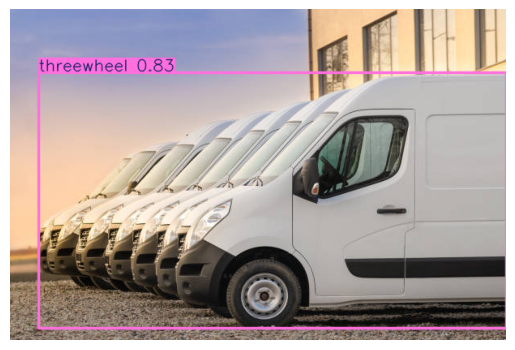

In [ ]:
from ultralytics import YOLO # Import the YOLO module from the ultralytics library
import cv2  # For loading images in a format that matplotlib can handle
import matplotlib.pyplot as plt


# Load the best trained model by providing the path to the saved weights (best.pt)
# This loads the model that was saved after training and is ready for predictions.
model = YOLO("/content/drive/MyDrive/Colab_Notebooks/Assignment_CV/vehicle_dataset/runs/detect/train4/weights/best.pt")

# Run prediction
# source: Path to the image on which predictions will be made.
# save: Save the output (with predictions) to the disk.
# configeration: Confidence threshold for making predictions - set to 0.5 (50% confidence).
results = model.predict(source="/content/drive/MyDrive/Colab_Notebooks/Assignment_CV/vehicle_dataset/test_images/vehicle1.jpg", save=False, conf=0.5)

# Extract the output image with predictions
output_image = results[0].plot()  # Plotting the results will return the image with annotations

# Convert the BGR image (used by OpenCV) to RGB (used by matplotlib)
output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

# Display the image with matplotlib
plt.imshow(output_image_rgb)
plt.axis('off')  # Hide axes for a cleaner display
plt.show()

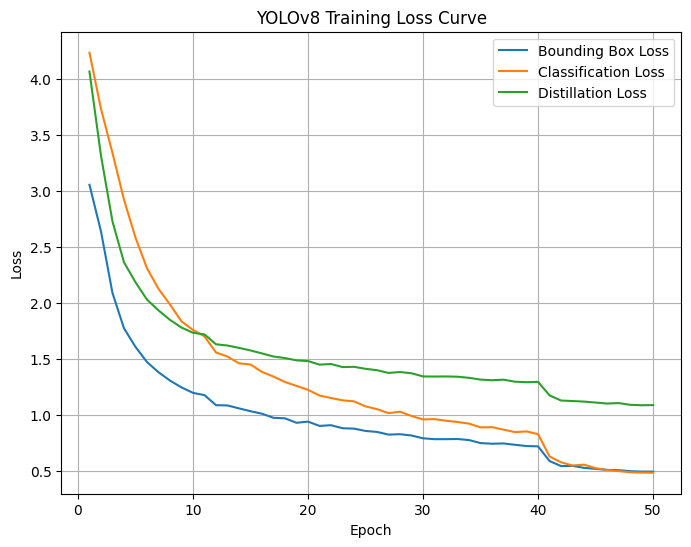

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to training logs
log_path = "/content/drive/MyDrive/Colab_Notebooks/Assignment_CV/vehicle_dataset/runs/detect/train4/results.csv"

# Load the training logs
df = pd.read_csv(log_path)

# Plot training loss over epochs
plt.figure(figsize=(8, 6))
plt.plot(df['epoch'], df['train/box_loss'], label="Bounding Box Loss")
plt.plot(df['epoch'], df['train/cls_loss'], label="Classification Loss")
plt.plot(df['epoch'], df['train/dfl_loss'], label="Distillation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("YOLOv8 Training Loss Curve")
plt.legend()
plt.grid()
plt.show()

Ultralytics 8.3.118 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 53.2±50.7 MB/s, size: 141.3 KB)


val: Scanning /content/drive/MyDrive/Colab_Notebooks/Assignment_CV/vehicle_dataset/valid/labels.cache... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:00<?, ?it/s]

val: /content/drive/MyDrive/Colab_Notebooks/Assignment_CV/vehicle_dataset/valid/images/car55.jpg: corrupt JPEG restored and saved



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 57/57 [00:14<00:00,  3.97it/s]


                   all        900       1150       0.94      0.893      0.952      0.837
                   car        182        201      0.915      0.905      0.936       0.89
                 truck        167        227      0.948      0.892      0.966      0.831
                   bus        162        185      0.983      0.928      0.981      0.915
             motorbike        123        151      0.902      0.914      0.959      0.823
                   van        165        216      0.931       0.81      0.908       0.65
            threewheel        157        170      0.959      0.906       0.96      0.914
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val8
Precision: 0.9396
Recall: 0.8926
mAP@0.5: 0.9518
mAP@0.5:0.95: 0.8371
F1 Score: 0.9155


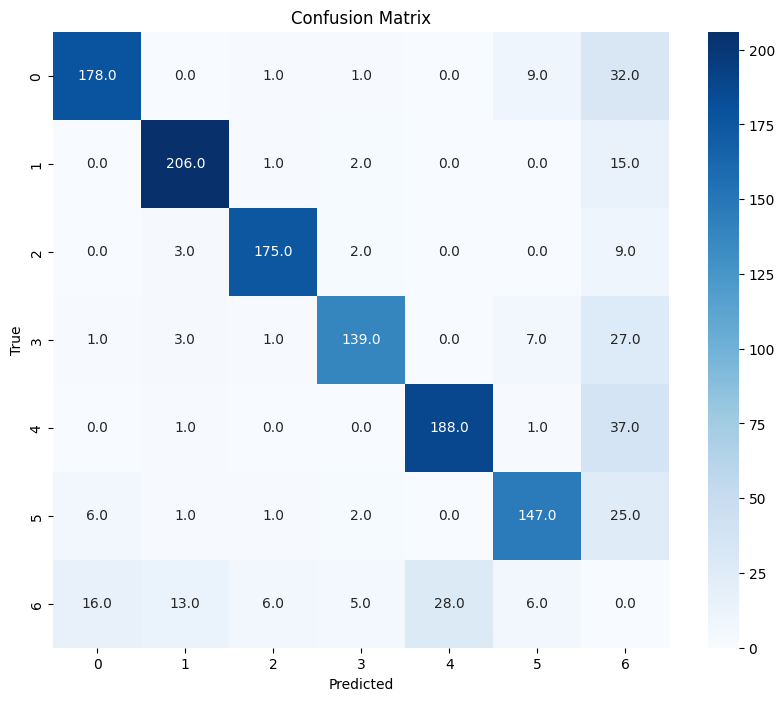

In [ ]:
# Evaluation metrices for YOLOv8 model
from ultralytics import YOLO

# Load trained model
model = YOLO("/content/drive/MyDrive/Colab_Notebooks/Assignment_CV/vehicle_dataset/runs/detect/train4/weights/best.pt")

# Validate model
metrics = model.val(
    data="/content/drive/MyDrive/Colab_Notebooks/Assignment_CV/vehicle_dataset/data.yaml",
    split='val',
    imgsz=640,
    batch=16
)

# Print important metrics
print("=====================================================")

precision = metrics.box.mp
recall = metrics.box.mr
map50 = metrics.box.map50
map_50_95 = metrics.box.map

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"mAP@0.5: {map50:.4f}")
print(f"mAP@0.5:0.95: {map_50_95:.4f}")

f1_score = 2 * (precision * recall) / (precision + recall + 1e-16)
print(f"F1 Score: {f1_score:.4f}")


# =============================================
# Plot Confusion Matrix
# =============================================

# Manually plotting the results in confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get confusion matrix from metrics.confusion attribute
conf_matrix = metrics.confusion_matrix.matrix

# Plot it the evaluation results
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt=".1f", cmap="Blues", square=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()